In this notebook, we demonstrate how to use tensorflow API to design and implement a matrix factorization model for predicting the movie ratings on the movie lens 1m dataset.

In our dataset, we have user ids and movie ids and ratings from each user on different movies. This gives us information of user preferences. 

Using this information, we want to learn movie and user features and use these features to predict the rating, so that we can recommend the potentially highest rated movies to our users. 

![ALS matrix factorization model](Picture1.png)

- users $\{1,...,N\}$ with user features $\{\theta_1,...,\theta_N\} =: \theta$
- movies $\{1,...,M\}$ with movie features $\{\phi_1,...,\phi_M\} =: \phi$
- dataset $D = \{r_{i,j}: user\ i\ has\ rated\ movie\ j\}$ of all ratings
- predicted rating of user $i$ of movie $j$: $\hat{r}_{i,j} = \theta_i^T \cdot \phi_j$
- cost function $J(\theta, \phi)  = \sum_{r_{i,j} \in D} (r_{i,j} - \hat{r}_{i,j})^2$
- We will use ALS method for matrix factorization. This means we calculate two gradients of our cost function $\nabla_\theta J$ and $\nabla_\phi J$ independently in order to update our parameters $\theta$ and $\phi$ one after another.
 
We will achieve this in following steps:
1. Load the movielens data into a pandas dataframe for preprocessing
2. Set up our parameters: $\theta$ and $\phi$
3. Load the data into a tensorflow variable
4. Define the prediction and cost
5. Start the session and run training, evaluation and finally predictions

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### download data

First download the data from movie lens website. Once the data file is unzipped, there are three files that we are using-- user.csv, movie.csv and rating.csv.

In [2]:
#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip

### data preprocessing

step 1: load data to pandas dataframes, merge the dataframes to one table.

In [3]:
age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
occupation_desc = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

Step 2: preprocess the movie id and user id

In [4]:
def check_cols(df, cols):
    """
    check if there are gaps of index, and if the index starts from 0
    
    Arguments:
    df -- dataframe of the dataset
    cols -- dataframe columns that needs to be checked, in our case user id and movie id
    
    Returns:
    a list of tuple [('COLUMN_NAME', boolean)], if True, the column needs to be fixed, if False, the column is ok.
    """
    return [(col, False) if len(dataset[col].unique())-1 == dataset[col].max() else (col, True) for col in cols]

def remove_gaps(df, col):
    """
    preprocess the index of user id and movie id to start from 0 and eliminate gaps in the index
    
    Arguments:
    df -- dataframe of the dataset
    col -- dataframe columns that needs to be adjusted, in our case both user id and movie id
    
    Returns:
    a dataframe with adjusted columns.
    """
    adj_col_uni = df[col].sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0: col, 'index': "adj_%s"%(col,)})
    return pd.merge(adj_df, df, how="right", on=col)

In [5]:
index_cols = ["userid", "movieid"]
cols_check = check_cols(dataset, index_cols)
print_check = lambda check: print(*["%s needs fix!"%(c,) if f else "%s ok."%(c,) for c, f in check], sep="\n")
print("before fix:")
print_check(cols_check)
for col, needs_fix in cols_check:
    if needs_fix:
        dataset = remove_gaps(dataset, col)

print("\nafter fix")
print_check(check_cols(dataset, ["adj_userid", "adj_movieid"]))

before fix:
userid needs fix!
movieid needs fix!

after fix
adj_userid ok.
adj_movieid ok.


step 3: shuffle data and split the data to train and validation set.

In [6]:
dataset = dataset.sample(frac=1, replace=False)
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### build the model

>Recall that following is our model:
<div class="alert alert-block alert-info">
- users $\{1,...,N\}$ with user features $\{\theta_1,...,\theta_N\} =: \theta$<br>
- movies $\{1,...,M\}$ with movie features $\{\phi_1,...,\phi_M\} =: \phi$<br>
- dataset $D = \{r_{i,j}: user\ i\ has\ rated\ movie\ j\}$ of all ratings<br>
- predicted rating of user $i$ of movie $j$: $\hat{r}_{i,j} = \theta_i^T \cdot \phi_j$<br>
- cost function $J(\theta, \phi)  = \sum_{r_{i,j} \in D} (r_{i,j} - \hat{r}_{i,j})^2$<br>
- We will use ALS method for matrix factorization. This means we calculate two gradients of our cost function $\nabla_\theta J$ and $\nabla_\phi J$ independently in order to update our parameters $\theta$ and $\phi$ one after another.</div>

In [10]:
def initialize_features(num_users, num_movies, dim):
    """
    Initialize features. User_features and movie_features need to be trained by the matrix factorization model.
    
    Arguments:
    num_users -- number of users
    num_movies -- number of movies
    dim -- dimension of learned user and movie features, it's a hyper-parameter
    
    Returns:
    user_features -- a matrix (variable) of shape [number of users, dim]
    movie_features -- a matrix (variable) of shape [number of movies, dim]
    """ 
    user_features = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_features = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_features, movie_features

def create_dataset(user_ids, movie_ids, ratings):
    """
    Load user id, movie id and rating values. Turn numpy array to tensors.
    
    Arguments:
    user_ids -- user index
    movie_ids -- movies index
    ratings -- true rating value
    
    Returns:
    user_id_var -- a constant of shape [number of training examples, 1]
    movie_id_var -- a constant of shape [number of training examples, 1]
    ratings_var -- a constant of shape [number of training examples, 1]
    """ 
    user_id_var = tf.constant(name="userid", value=user_ids)
    movie_id_var = tf.constant(name="movieid", value=movie_ids)
    ratings_var = tf.constant(name="ratings", value=np.asarray(ratings, dtype=np.float32))
    return user_id_var, movie_id_var, ratings_var
   
def lookup_features(user_features, movie_features, user_ids, movie_ids): 
    """
    Retrieve embeddings based on user ids and movie ids respectively.
    We use tf.gather function for this. tf.gather gathers slices from params according to indices.
    
    Arguments:
    user_features -- shape [number of user ids, dim]
    movie_features -- shape [number of movie ids, dim]
    user_ids -- user id tensor (in our case loaded user ids from dataset)
    movie_ids -- movie id tensor (in our case loaded movie ids from dataset)
    
    Returns:
    selected_user_features -- a tensor of shape [number of examples, dim]
    selected_movie_features -- a tensor of shape [number of examples, dim]
    """ 
    selected_user_features = tf.gather(user_features, user_ids)
    selected_movie_features = tf.gather(movie_features, movie_ids)
    return selected_user_features, selected_movie_features

def predict(selected_user_features, selected_movie_features):
    """
    Calculate predictions. This is the dot product of user features and movie features. 
    For each training example, this corresponds to a single number.
    
    Arguments:
    selected_user_features -- matrix of user features for each example -- shape [number of examples, dim]
    selected_movie_features -- matrix of movies features value for each example -- shape [number of examples, dim]
    
    Returns:
    selected_predictions -- a tensor of shape [number of examples, 1]
    """ 
    selected_predictions = tf.reduce_sum(
        selected_user_features * selected_movie_features,
        axis = 1
    )
    ##alternatively, using tf.reduce_sum(tf.multiply(selected_user_embeddings,selected_movie_embeddings), axis=1)
    return selected_predictions

def mean_squared_difference(predictions, ratings):
    """
    Calculate cost.
    
    Arguments:
    predictions -- predicted ratings.
    ratings -- true ratings.
    
    Returns:
    difference -- mean squared error. It's a real number. 
    """ 
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference

### set hyper parameters

In [11]:
emb_dim = 8
learning_rate = 50
epochs = 1000

### train model

Here we define the tensorflow graph and create the session to compute the values.

From the tensorflow documentation:
 - A graph defines the computation. It doesn’t compute anything, it doesn’t hold any values, it just defines the operations that you specified in your code.
 - A session allows to execute graphs or part of graphs. It allocates resources (on one or more machines) for that and holds the actual values of intermediate results and variables.

In [12]:
with tf.Graph().as_default():
    with tf.variable_scope("features"):
        usr_embs, mov_embs = initialize_features(len(dataset.adj_userid.unique()), len(dataset.adj_movieid.unique()), emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T #shape(3, 700146)
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)# expend to 3 lists
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_sel_usr_emb, train_sel_mov_emb = lookup_features(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_preds = predict(train_sel_usr_emb, train_sel_mov_emb)
        train_loss = mean_squared_difference(train_preds, train_ratings)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])   
    with tf.variable_scope("validation"):
        valid_sel_usr_emb, valid_sel_mov_emb = lookup_features(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_preds = predict(valid_sel_usr_emb, valid_sel_mov_emb)
        valid_loss = mean_squared_difference(valid_preds, valid_ratings)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('Graph/MF',sess.graph)
        sess.run(tf.global_variables_initializer())
        train_loss_history = []
        valid_loss_history = []
        for i in range(epochs):
            current_train_loss, _ = sess.run([train_loss, train_usr_embs])
            current_train_loss, _ = sess.run([train_loss, train_mov_embs])
            current_valid_loss = sess.run(valid_loss)
            if i%100 ==0:
                print("valid loss at step %i: %f"%(i+1, current_valid_loss))
            train_loss_history.append(current_train_loss)
            valid_loss_history.append(current_valid_loss)
        final_user_features, final_movie_features = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds) 
        writer.close()

valid loss at step 1: 14.061668
valid loss at step 101: 1.053597
valid loss at step 201: 0.873390
valid loss at step 301: 0.833664
valid loss at step 401: 0.804873
valid loss at step 501: 0.786872
valid loss at step 601: 0.775171
valid loss at step 701: 0.767974
valid loss at step 801: 0.763356
valid loss at step 901: 0.760175


### plot losses

plot the traing loss and valid loss

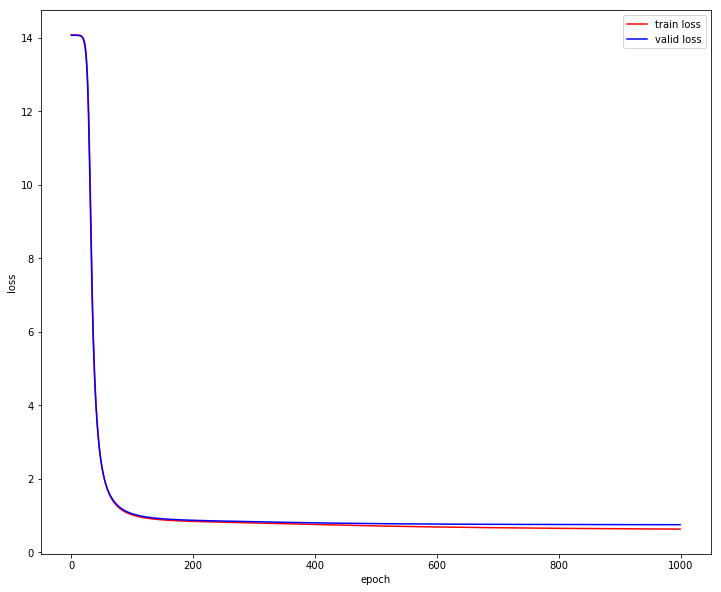

In [10]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_history, color="red", label="train loss")
plt.plot(valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
mf_accuracy = np.sum(np.round(final_valid_predictions) == validset.rating.values) / len(final_valid_predictions)
print("MF Accuracy: %f%%"%(mf_accuracy*100,))

MF Accuracy: 45.008881%


### results on validation set

In [17]:
results = validset[["gender", "userid","movieid","age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction (rnd.)"] = np.asarray(np.round(final_valid_predictions), dtype=np.int16)
results["prediction (prc.)"] = final_valid_predictions
results.head(50)

,gender,userid,movieid,age_desc,occ_desc,title,genre,rating,prediction (rnd.),prediction (prc.)
323753,M,3432,1220,25-34,programmer,"Blues Brothers, The (1980)",Action|Comedy|Musical,4,4,3.595490
572412,M,3579,2089,18-24,other or not specified,"Rescuers Down Under, The (1990)",Animation|Children's,3,3,2.909302
473636,M,3931,1680,25-34,customer service,Sliding Doors (1998),Drama|Romance,4,4,3.858740
308120,M,4378,1203,18-24,technician/engineer,12 Angry Men (1957),Drama,3,3,3.197440
621235,M,4251,2301,45-49,executive/managerial,History of the World: Part I (1981),Comedy,2,3,3.245275
280736,M,1482,1127,25-34,executive/managerial,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,3,4,3.565892
251324,M,2414,1033,25-34,academic/educator,"Fox and the Hound, The (1981)",Animation|Children's,4,4,3.941283
178892,M,4732,648,25-34,sales/marketing,Mission: Impossible (1996),Action|Adventure|Mystery,3,3,3.208387
723124,M,4439,2694,35-44,doctor/health care,Big Daddy (1999),Comedy,3,3,3.135849
83939,M,727,317,35-44,lawyer,"Santa Clause, The (1994)",Children's|Comedy|Fantasy,4,4,3.934950


### Measures

In [12]:
### Precision, Recall, MAE, RMSE measures:

def compute_recall(prediction_col, target_col):
    recall=[]
    for i in range(5):
        rating_df = results[results[target_col]==i+1]
        num_true_rating = len(rating_df)+0.0
        current_recall = (len(rating_df[rating_df[prediction_col]==i+1]))/num_true_rating
        recall.append(current_recall)
    return recall

def compute_precision(prediction_col, target_col): 
    precision=[]
    for i in range(5):
        pred_df = results[results[prediction_col]==i+1]
        pred_rating = len(pred_df)+0.0
        current_precision = (len(pred_df[pred_df[target_col]==i+1]))/pred_rating
        precision.append(current_precision)
    return precision    

def compute_mae(prediction_col, target_col):
    return np.mean(np.abs(results[prediction_col]-results[target_col]))

def compute_rmse(prediction_col, target_col):
    return np.sqrt(1/len(results)*np.sum((results[prediction_col]- results[target_col])**2))

In [13]:
compute_recall('prediction (rnd.)', 'rating')

[0.12242835057676299,
 0.2602769297190613,
 0.502085911485909,
 0.6385712646755134,
 0.2782322852636389]

In [14]:
compute_precision('prediction (rnd.)', 'rating')

[0.6914036265950302,
 0.3469681397738952,
 0.4058722824965967,
 0.45429626657053657,
 0.6664430478073582]

In [15]:
compute_mae('prediction (rnd.)', 'rating')

0.6391991015220138

In [16]:
compute_rmse('prediction (rnd.)', 'rating')

0.91609156911837586